## 2d-plot snpVAF vs log2ratio and assign CNVstatus for individual blocks

### SETUP

In [1]:
# HOME
home = '/Users/mahtin'
home = '/Users/martinscience'

import os
import matplotlib as mpl
import matplotlib.pyplot as plt
# use seaborn plotting defaults
import seaborn as sns; sns.set()

# get the code
import sys
sys.path.append('../scripts')
from codeCNV.plot import plot_genomic, plot_snp2, plot_snp, plot_2d, plot_3d
from script_utils import show_output

# load the config
# edit config directly in yaml file
import yaml
config_file = '../config/config_devel.yaml'
def get_config(config_file, param):
        with open(config_file) as file:
        # The FullLoader parameter handles the conversion from YAML
        # scalar values to Python the dictionary format
            config = yaml.load(file, Loader=yaml.FullLoader)['CNV'][param]
        return config
config = get_config(config_file, 'cluster')

# load the paths
wes_path = f"{home}/Dropbox/Icke/Work/somVar/AMLMono7/WESData"
plot_path = f'{wes_path}/CNVplots/cluster'

###  get the sample
+ from the sample_df

In [2]:
def get_sample(sample):
    s = sample.replace("_", "")
    sample_df = pd.read_excel(os.path.join(wes_path, "cluster_samples.xlsx")).set_index('sample')
    return sample_df.loc[s, "file"]

get_sample("06A")

'/Users/martinscience/Dropbox/Icke/Work/somVar/AMLMono7/WESData/P483/CNV/06_A.cluster'

In [3]:
sample = "06A"
cluster_df = pd.read_csv(get_sample(sample), sep='\t')
cluster_df

,Chr,Pos,FullExonPos,ExonPos,log2ratio,log2ratiomean,VAF,absVAF,absVAFmean,covCNV,covCNVcore,covCenter,covCentercore,snpCNV,snpCNVcore,snpCenter,snpCentercore
0,chr1,17385,1709,1709,-0.212125,-0.461107,0.226667,0.491763,0.177521,0.0,0.0,0.0,0.0,0,0,0,0
1,chr1,17614,1938,1938,-0.558398,-0.461107,0.098591,0.747914,0.163440,0.0,0.0,0.0,0.0,0,0,0,0
2,chr1,873939,10334,10334,-0.170628,-0.461107,0.105960,0.733177,0.126633,2.0,1.0,0.0,0.0,0,0,0,0
3,chr1,946247,14293,14292,-0.514392,-0.515981,0.509091,0.073085,0.108062,2.0,1.0,0.0,0.0,0,0,0,0
4,chr1,979472,23981,23981,-0.500838,-0.478433,0.432624,0.079849,0.120287,2.0,0.0,0.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24721,chrX,153783192,49332786,1698323,-0.752737,-0.519778,0.458333,0.028431,0.095726,770.0,0.0,0.0,0.0,0,0,0,0
24722,chrX,153789757,49335855,1701392,-0.198781,-0.510964,0.469816,0.005465,0.089473,770.0,0.0,0.0,0.0,0,0,0,0
24723,chrX,153864101,49341718,1707256,-0.166982,-0.461593,0.526316,0.107535,0.087228,770.0,1.0,0.0,0.0,0,0,0,0
24724,chrX,153870192,49345165,1710702,-0.537146,-0.444845,0.460674,0.023749,0.086683,770.0,1.0,0.0,0.0,0,0,0,0


### strategy
+ get the means and sigma from the center_df
+ adjust absVAF and log2ratio of CNV_df
+ plot
+ find most likely purity by llh2d_mask

In [4]:
def center_data(cluster_df):
    '''
    get the center_df containing only points belonging to both Centercores
    '''
    
    cols = ['log2ratio', 'log2ratiomean', 'absVAF', 'absVAFmean']

    # get the center_df with points belonging to both Centercores
    center_df = cluster_df.query('covCentercore + snpCentercore == 2').copy()
    # get the mean and std for relevant columns
    center_params = center_df[cols + ['VAF']].agg(['mean', 'std']).T
    # get the cnv_df with at least one CNVcore per point
    cnv_df = cluster_df.query('snpCNVcore + covCNVcore > 0').copy()
    
    for col in cols:
        center_df.loc[:, col] = center_df[col] - center_params.loc[col, 'mean']
        cnv_df.loc[:, col] = cnv_df[col] - center_params.loc[col, 'mean']
        
    cnv_df.loc[:, 'VAF'] = cnv_df['VAF'] + 0.5 - center_params.loc['VAF', 'mean']
    center_df.loc[:, 'VAF'] = center_df['VAF'] + 0.5 - center_params.loc['VAF', 'mean']
    return cnv_df, center_df, center_params

In [5]:
cnv_df, center_df, center_params = center_data(cluster_df)
center_params

,mean,std
log2ratio,-0.096450,0.341331
log2ratiomean,-0.031378,0.133299
absVAF,0.116135,0.184999
absVAFmean,0.116627,0.048148
VAF,0.462270,0.108733


### 2-dimensional llh

In [6]:
def llh2d(dx, dy, mx=0, my=0, sx=0.5, sy=0.1):
    '''
    compute the density function for a given gaussian
    takes a pd.Series or np.array
    '''   
    # get the fixed term
    s = 2 * np.pi * sx * sy
    return np.exp((((dx - mx) / sx) **2 + ((dy - my) / sy) **2) / -2) / s

### get all the means depending on alpha
+ will be used for making gaussians


In [7]:
# start with a simple dataFrame
import math

def get_gauss_mask(alpha, Nmax):
    '''
    returns the gauss params for the gauss mask
    '''
    
    alpha = min(1,alpha)
    df = pd.DataFrame()
    for n in range(int(Nmax)):
        N = n + 1 
        for i in range(math.ceil((N + 1) / 2)):
            string = "A" * (N - i) + "B" * i
            if string == 'A':
                string = 'LOH'
            absVAF = alpha * np.abs((2 * i) / N - 1)
            log2 = np.log2(2 + alpha * (N - 2)) - 1
            s = pd.Series({'type': string, 'absVAF': absVAF, 'log2ratio': log2})
            df = df.append(s, ignore_index=True)
    return df.query('(absVAF !=0 or log2ratio != 0) or type == "AB"')


Nmax = 4
alpha = 1
gauss_mask = get_gauss_mask(alpha, Nmax)
gauss_mask

,absVAF,log2ratio,type
0,1.000000,-1.000000,LOH
1,1.000000,0.000000,AA
2,0.000000,0.000000,AB
3,1.000000,0.584963,AAA
4,0.333333,0.584963,AAB
5,1.000000,1.000000,AAAA
6,0.500000,1.000000,AAAB
7,0.000000,1.000000,AABB


+ ####  mask2VAF for converting to VAF gaussians

In [8]:
def mask2VAF(mask_df):
    '''
    converts the gauss_mask for absVAF into mask for VAF
    '''
    
    df = mask_df.copy()
    df.loc[:, 'VAF-'] = 0.5 - df['absVAF'] / 2
    df.loc[:, 'VAF+'] = 0.5 + df['absVAF'] / 2
    return df.loc[:, ['VAF-','VAF+', 'log2ratio', 'type']]


def VAFmask(alpha, Nmax=6):
    return mask2VAF(get_gauss_mask(alpha, Nmax))

VAFmask(alpha, Nmax)

,VAF-,VAF+,log2ratio,type
0,0.000000,1.000000,-1.000000,LOH
1,0.000000,1.000000,0.000000,AA
2,0.500000,0.500000,0.000000,AB
3,0.000000,1.000000,0.584963,AAA
4,0.333333,0.666667,0.584963,AAB
5,0.000000,1.000000,1.000000,AAAA
6,0.250000,0.750000,1.000000,AAAB
7,0.500000,0.500000,1.000000,AABB


In [9]:
plt.style.use('seaborn-white')

def plot_gaussian(df, xcol, ycol, 
                  df2=pd.DataFrame(), 
                  Nmax=0,   # maximal expected
                  alpha=1,
                  gauss_params=pd.DataFrame(), # the center_params containing the std
                  logmax=2.5, 
                  std_factor = 1,
                  rings=10, # number of rings for contour
                  figsize=(6, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    _ = ax.scatter(df[xcol], df[ycol], s=.1)
    if len(df2.index):
        _ = ax.scatter(df2[xcol], df2[ycol], s=2.5, alpha=.5, color='red')
    _ = ax.set_xlabel(xcol, fontsize=15)
    _ = ax.set_ylabel(ycol, fontsize=15)
    _ = ax.set_title(f"alpha={alpha}", fontsize=20)
    _ = sns.despine(ax=ax, offset=0)
    _ = ax.spines['left'].set_position('zero')

    
    def get_lims(col):
        if 'log' in col:
            return (-1.5, logmax)
        if 'VAF' in col:
            return (-0.05, 1.05)
    _ = ax.set_xlim(get_lims(xcol))
    _ = ax.set_ylim(get_lims(ycol))
    
    # add gaussian mask
    if Nmax:
        # create the grid
        x = np.linspace(*get_lims(xcol), 500)
        y = np.linspace(*get_lims(ycol), 400)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)
        
        # get the std from the params
        sx, sy = gauss_params.loc[[xcol, ycol], 'std']
        print(sx, sy)
        sx *= std_factor
        sy *= std_factor
        gaussians = get_gauss_mask(alpha, Nmax)
        if xcol == 'VAF':
            gaussians = mask2VAF(gaussians)
            for _, row in gaussians.iterrows():
                mx1 = row['VAF-']
                mx2 = row['VAF+']
                my = row['log2ratio']
                Z += llh2d(X,Y, mx1, my, sx, sy) +   llh2d(X,Y, mx2, my, sx, sy)
                ax.text(mx1, my-0.2, row['type'], ha='center')
                # add the mirror cluster unless it is AB
                if not row['type'] == "AB":
                    ax.text(mx2, my-0.2, row['type'].replace('A', 'G').replace('B', 'A').replace('G', 'B'), ha='center')
        else:
            for _, row in gaussians.iterrows():
                mx = row['absVAF']
                my = row['log2ratio']
                Z += llh2d(X,Y, mx, my, sx, sy)
                ax.text(mx, my-0.2, row['type'], ha='center')
        _ = ax.contour(X,Y,Z, rings, colors='black', alpha=1,linewidths=.4)
    # set the y-spine
    _ = ax.axhline(y=0, color='k')
    _ = ax.axvline(x=0, color='k')
    _ = ax.axvline(x=1, color='k')
    if xcol == 'VAF':
        _ = ax.axvline(x=0.5, c='k',ls="--")

    return fig, ax

## test samples

In [10]:
log2 = dict(
        title='log2ratio',
        plot_type='scatter',   # ['line', 'scatter']
        data='log2ratio',
        plot_args=dict(
            linewidth=0.3,
            color='black',
            s=2,
            alpha=1
        )
    )

log2mean = dict(
        title='rollinglog2ratio',
        plot_type='line',   # ['line', 'scatter']
        data='log2ratiomean',
        plot_args=dict(
            linewidth=2,
            color='yellow',
            alpha=1
        )
    )
vaf = dict(
        title='VAF',
        plot_type='scatter',   # ['line', 'scatter']
        data='VAF',
        plot_args=dict(
            linewidth=1,
            color='black',
            s=3,
            alpha=1
        ))

fig_params = dict(
    figsize=(48,12),
    colormap='coolwarm_r',
    color_chroms=True,
    ylim=(0,1),
    cov_offset=.1,  # how much log2ratio=0 is shifted above SNP-data
    cov_height=.5,
    label_size=13
)

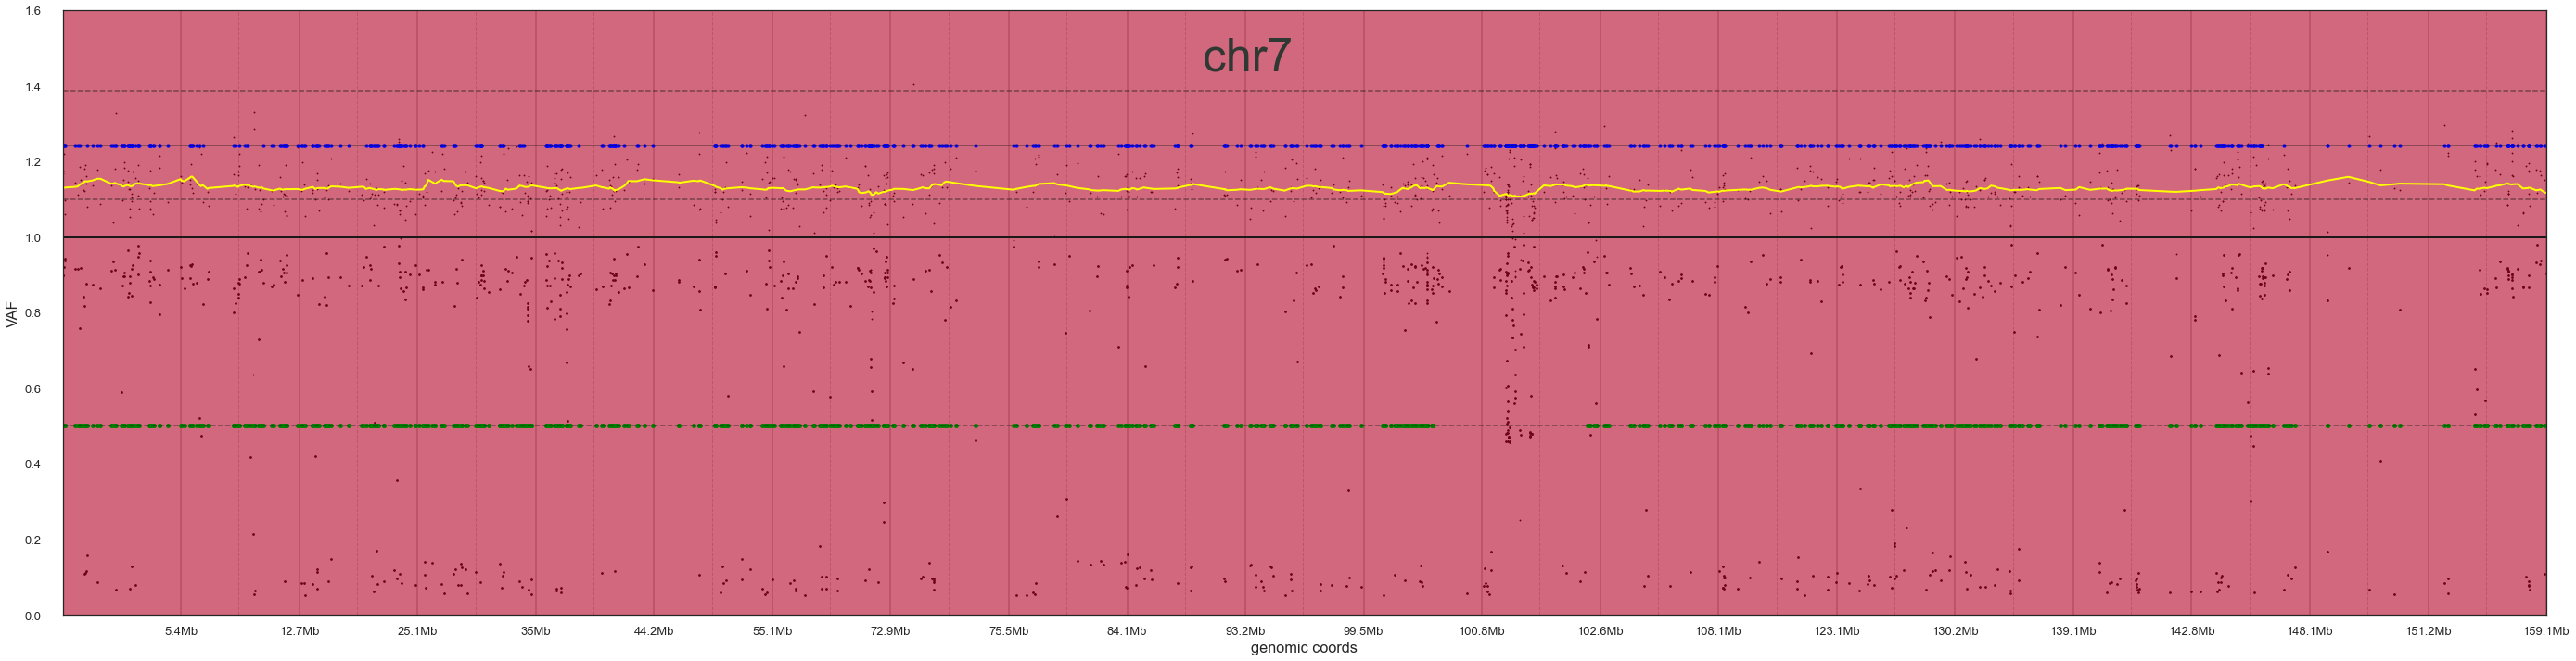

In [27]:
sample = "04A"
cluster_df = pd.read_csv(get_sample(sample), sep='\t')
chroms = ['chr5', 'chr7','chr8', 'chr11', 'chr17']
cnv_df, center_df, center_params = center_data(cluster_df)
fig, _, _, _ = plot_snp2(cluster_df, snp_plots=[vaf], cov_plots=[log2, log2mean], blocks=["snpCNVcore", "covCNVcore"], chroms='all', region='chr7', **fig_params)
# fig.savefig(os.path.join(f"/Users/martinscience/Desktop/CNVAML/new/{sample}_blocks.jpg"),pil_kwargs=dict(quality=90))

In [28]:
cluster_df['covCNV'].unique()

array([ 0.,  2.,  4.,  6.,  8., 12., 14., 16., 18., 10.])

0.11664148829812851 0.06013868241712256


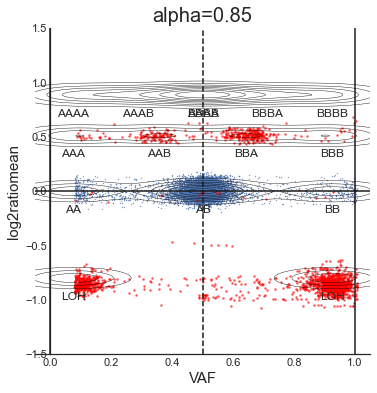

In [14]:
cnv_df, center_df, center_params = center_data(cluster_df)
xcol = 'VAF'
ycol = 'log2ratiomean'
fig, ax = plot_gaussian(center_df, df2=cnv_df, xcol=xcol, ycol=ycol, 
                        Nmax=4, 
                        rings=8, 
                        logmax=1.5,
                        alpha=.85, 
                        std_factor=1,
                        gauss_params=center_params
                       )
# fig.savefig(os.path.join(f"/Users/martinscience/Desktop/CNVAML/new/{sample}_cluster.jpg"),pil_kwargs=dict(quality=90))

## do the block assignment according to LLH
+ LLH2D computation has to be done for every possible gaussian
+ data can be computed for entire CNV_df
+ grouped sums can then be maximized
+ center params are needed for gaussians

In [29]:
def get_means(row):
    '''
    row helper for extracting the means from the VAFmask after extraction of alpha and CNVstatus
    '''
    return VAFmask(float(row['a'])).set_index("type").loc[row['type']]


def get_all_means(df):
    '''
    retrieves the means for VAF and log2ratiomean from the CNVcall for visualization
    '''
    
    df[['a', 'type']] = df['CNVcall'].str.extract(r"([0-9.]+)-([ABLOH]+)")
    df[['VAF-', 'VAF+', 'log2ratio']] = df.apply(get_means, axis=1)
    return df.drop(['a', 'type'], axis=1)


def call_blocks(df, alpha=0.9, Nmax=6, center_params=pd.DataFrame()):
    '''
    takes a cluster_df and makes the CNV calls
    1. computes the 2D-LLH for every given alpha and possible CNVstatus (VAF-symmetric)
    2. assigns the CNV-status per group where the LLH-sum is maximal
    3. outputs the blocks with CNV-status and imputed means for visualization
    '''
    # get the std from center_params
    vaf_std = center_params.loc['VAF', 'std']
    log2_std = center_params.loc['log2ratiomean', 'std']
    
    # force list for alpha
    if not isinstance(alpha, list):
        alpha = [alpha] 
    
    # add a column for every CNV type and every alpha
    # and calculate the respective 
    for a in alpha:
        # cycle through the VAFmask (containing the means for the respective gaussians)
        mask = VAFmask(a, Nmax)
        for _, row in mask.iterrows():
            df[f"{a}-{row['type']}"] = llh2d(df['VAF'],df['log2ratiomean'], mx=row['VAF-'], my=row['log2ratio'], sx=vaf_std, sy=log2_std)
            df[f"{a}-{row['type']}"] += llh2d(df['VAF'],df['log2ratiomean'], mx=row['VAF+'], my=row['log2ratio'], sx=vaf_std, sy=log2_std)
    
    # reduce df to the sums of LLH per CNVtype
    # reduce to required columns and group by snpCNV
    cnv_df = df.loc[:, ['snpCNV'] + [f"{a}-{m}" for a in alpha for m in mask['type']]].groupby('snpCNV').sum()
    
    cnv_df['CNVcall'] = cnv_df.columns[np.argmax(cnv_df.values, axis=1)]
    
    # get the start and end coordinates for each group
    region_df = df.loc[:, ['Chr', 'Pos', 'snpCNV']].groupby(['snpCNV', 'Chr'])['Pos'].agg(["min", "max"]).rename({'min':'Start', 'max': 'End'}, axis=1).reset_index('Chr')
    
    # merge the region into the cnv_df
    block_df = cnv_df.merge(region_df, left_index=True, right_index=True).loc[:, ['Chr', 'Start', 'End', 'CNVcall']]
    
    # add the VAF and log2ratio means for 
    # sort the blocks using key callable for quick chrom sort
    block_df = get_all_means(block_df).sort_values(by=['Chr', 'Start'], key=lambda x: x.astype(str).str.replace("chr", "").str.replace("X", "23").astype(int))
    return block_df   # .loc[block_df['VAF-'] != 0.5, :]

In [30]:
df = cnv_df.copy()
block_df = call_blocks(df, [0.85, 0.4], 6, center_params)
block_df

,Chr,Start,End,CNVcall,VAF-,VAF+,log2ratio
snpCNV,,,,,,,
0,chr2,24146804,26444262,0.85-LOH,0.075000,0.925000,-0.798366
18,chr3,3034759,42557557,0.85-AB,0.500000,0.500000,0.000000
20,chr5,90473830,157494643,0.85-LOH,0.075000,0.925000,-0.798366
0,chr5,157509356,162067984,0.85-LOH,0.075000,0.925000,-0.798366
22,chr7,259884,100854110,0.85-LOH,0.075000,0.925000,-0.798366
0,chr7,100858989,101034245,0.85-LOH,0.075000,0.925000,-0.798366
24,chr7,101034275,159058543,0.85-AAB,0.358333,0.641667,0.510962
24,chr8,544658,144392426,0.85-AAB,0.358333,0.641667,0.510962
0,chr12,10420495,21178665,0.85-LOH,0.075000,0.925000,-0.798366


## look at different data and scale-fit

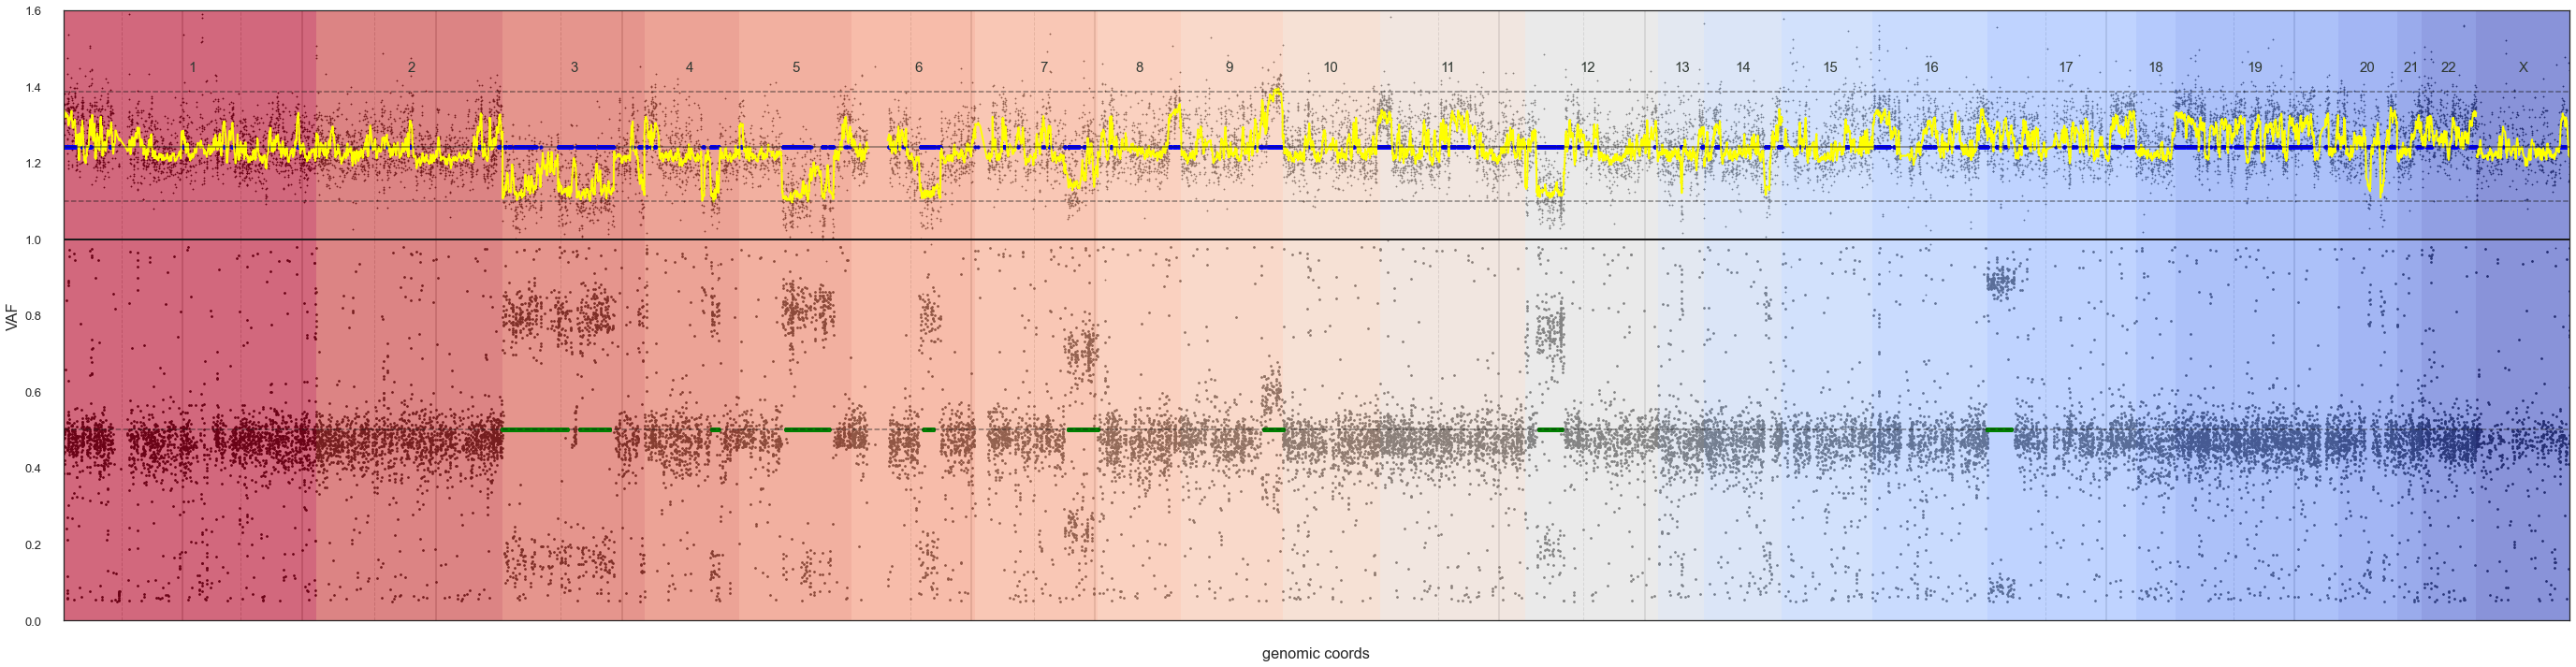

In [202]:
sample = "02A"
cluster_df = pd.read_csv(get_sample(sample), sep='\t')

fig, _, _, _ = plot_snp2(cluster_df, snp_plots=[vaf], cov_plots=[log2, log2mean], blocks=["snpCNVcore", "covCNVcore"], chroms='all', region='', **fig_params)
fig.savefig(os.path.join(f"/Users/martinscience/Desktop/CNVAML/new/{sample}_blocks.jpg"),pil_kwargs=dict(quality=90))

0.11859649311897717 0.07398026882163018
0.11859649311897717 0.07398026882163018
0.11859649311897717 0.07398026882163018


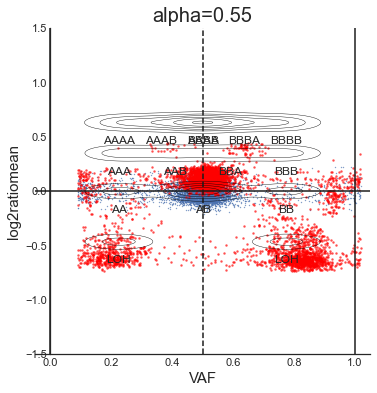

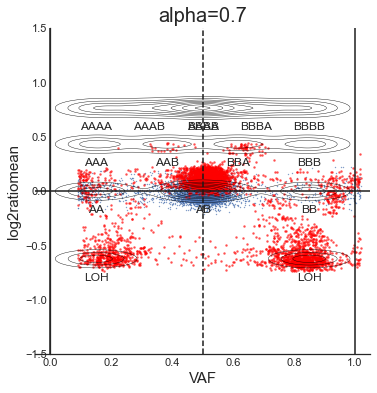

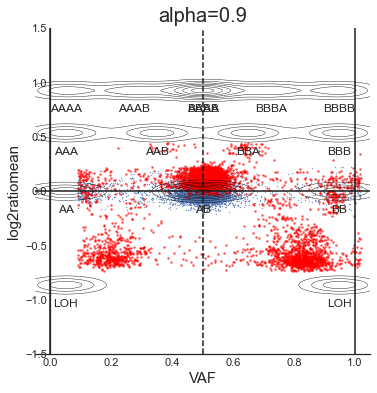

In [203]:
cluster_dff = cluster_df.copy()
alpha = [.55,.7,.9]
scale = .75
shift = -.3
cluster_dff['log2ratiomean'] = (cluster_dff['log2ratiomean'] + shift) * scale
cnv_df, center_df, center_params = center_data(cluster_dff)
cnv_df['log2ratiomean'] = (cnv_df['log2ratiomean'] + shift) * scale
for a in alpha:
    fig, ax = plot_gaussian(center_df, df2=cnv_df, xcol=xcol, ycol=ycol, 
                        Nmax=4, 
                        rings=8, 
                        logmax=1.5,
                        alpha=a, 
                        std_factor=.7,
                        gauss_params=center_params
                       )
    fig.savefig(os.path.join(f"/Users/martinscience/Desktop/CNVAML/new/{sample}_{a}cluster.jpg"),pil_kwargs=dict(quality=90))
block_df = call_blocks(cnv_df, alpha, 6, center_params)


In [204]:
block_df

,Chr,Start,End,CNVcall,VAF-,VAF+,log2ratio
snpCNV,,,,,,,
10,chr3,197630,66304487,0.7-LOH,0.150000,0.850000,-0.621488
12,chr3,100451784,100902582,0.7-LOH,0.150000,0.850000,-0.621488
14,chr3,105704000,146194390,0.7-LOH,0.150000,0.850000,-0.621488
16,chr3,194670140,195619441,0.55-LOH,0.225000,0.775000,-0.463947
20,chr4,119026891,140443425,0.7-LOH,0.150000,0.850000,-0.621488
22,chr5,96757518,151267451,0.7-LOH,0.150000,0.850000,-0.621488
24,chr6,73445623,106975455,0.7-LOH,0.150000,0.850000,-0.621488
26,chr7,128339293,159144683,0.55-LOH,0.225000,0.775000,-0.463947
28,chr9,129612322,138176567,0.55-AAB,0.408333,0.591667,0.350497


In [205]:
block_df.to_csv(os.path.join(wes_path, get_sample(sample).replace(".cluster", ".CNVcall")), sep='\t')